In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numbers
import random

In [3]:
import scipy.stats

### Relevant functions

In [4]:
# Copied from Vectorized EMD.ipynb
from typing import List
import lap

# return distance only, not result
def earth_mover_distance_1(samples1: np.ndarray, samples2: np.ndarray, radixes: List[int], question_types: List[str]):
    ## Sanity check
    if (samples1.shape != samples2.shape):
        print("samples1 and samples2 shape not the same!")
        return

    # N: number of samples in both samples1 and samples2
    numberOfSamples = samples1.shape[0]
    # Q: number of questions in the survey
    numberOfQuestions = samples1.shape[1]

    if (numberOfQuestions != len(radixes)):
        print("radixes length not match!")
        return

    if (numberOfQuestions != len(question_types)):
        print("question_types length not match!")
        return

    ## Calculating distance matrix
    # distance matrix (shape N*N). Element distance[x][y] denotes distance between x-th element in samples1 and y-th element in samples2
    distance = np.zeros((numberOfSamples, numberOfSamples))
    # Memoizes and eliminates unnecessary computations. (z, valueInX) => np.ndarray of cost
    memoMap = {}

    for z in range(0, numberOfQuestions):
        # radio and checkbox question: distance = 1 if different else 0
        if question_types[z] == "radio" or question_types[z] == "checkbox":
            # TODO: probably the following loop can be parallelized?
            for x in range(0, samples1.shape[0]):
                value = samples1[x][z]  # value of samples1 in this col
                
                # Note that we can memoize the operation here: for the same value, the cost contribution of *this question* will always be the same when comparing across entire samples2
                if (z, value) in memoMap.keys():
                    distance[x] += memoMap[(z, value)]
                else:
                    # Note that this operation is vectorized: numpy has builtin function for comparing & setting values
                    memo = np.where(samples2[:, z] == value, 0, 1)
                    memoMap[(z, value)] = memo
                    distance[x] += memo

        # estimate question: distance = absolute difference / radix
        else:
            radix = radixes[z]
            for x in range(0, samples1.shape[0]):
                value = samples1[x][z]
                if (z, value) in memoMap.keys():
                    distance[x] += memoMap[(z, value)]
                else:
                    # Note that this operation is vectorized: numpy has builtin function for subtracting and division across entire row
                    memo = np.abs((samples2[:, z] - value)/radix)
                    memoMap[(z, value)] = memo
                    distance[x] += memo

    ## Find minimum distance matching (i.e. EMD) with Jonker–Volgenant algorithm
    return distance

# return EMD
def earth_mover_distance(samples1: np.ndarray, samples2: np.ndarray, radixes: List[int], question_types: List[str]):
    distance = earth_mover_distance_1(samples1, samples2, radixes, question_types)
    return lap.lapjv(distance)[0]

In [5]:
# n is number of samples to create
# radixes describes what a sample should look like: possibilities for each sample
def createSamples(n, radixes):

    samples = []
    length = len(radixes)

    for x in range(n):
        sample = []
        for y in range(length):
            # for each item, randomly choose using probabilities
            radix = radixes[y]
            newNumber = random.randint(0, radix-1)
            sample.append(newNumber)
        samples.append(sample)

    return np.array(samples)

### Data Preprocessing

In [6]:
df_300 = pd.read_csv("../../PEW_Jun29_300.csv")

In [7]:
# Subtract min from all responses to estimate question. Simplifies random sample generation
c_age = df_300['What is your age?']
c_age -= c_age.min()

In [8]:
sample_300 = np.array(df_300.drop('Worker ID', axis=1).applymap(
    # convert answers to integers (within radix)
    lambda x: {
        # dictionary for radio question
        'Easier': 0,
        'Same': 1,
        'Harder': 2,
        # dictionary for boolean radio
        'Yes': 1,
        'No': 0,
    }.get(x, int(x) if isinstance(x, numbers.Number) else x) # if an estimate, make it an int number
))
sample_300

array([[ 2,  2,  2, ...,  0,  1, 20],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 2,  1,  0, ...,  2,  1, 21],
       ...,
       [ 0,  0,  0, ...,  0,  1, 33],
       [ 2,  2,  2, ...,  2,  1, 29],
       [ 0,  2,  0, ...,  0,  1, 35]])

In [9]:
question_types = ["radio", "radio", "radio", "radio", "radio", "radio", "radio", "radio", "estimate"]

c_age = df_300['What is your age?']
radix = [3, 3, 3, 3, 3, 3, 3, 2, int(c_age.max()-c_age.min())]

# Original

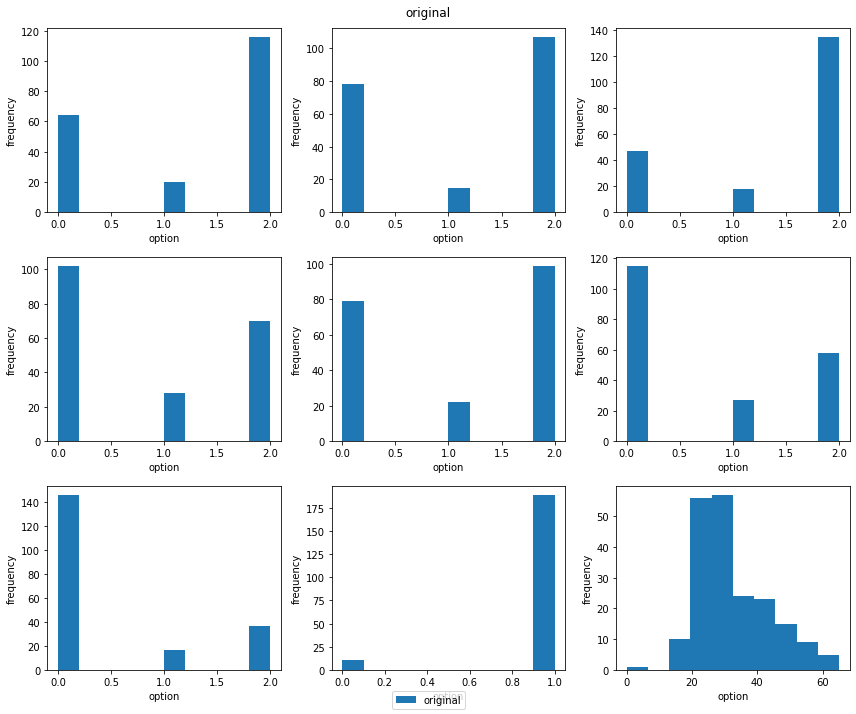

In [96]:
fig, axs = plt.subplots(3,3, figsize=(12,10))

for index in range(0,9):
    # plotting
    axs[index//3][index%3].hist(sample_300[:200,index], label=["original"])

    axs[index//3][index%3].set_xlabel("option")
    axs[index//3][index%3].set_ylabel("frequency")
    # axs[index//3][index%3].legend()
    
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')
fig.suptitle(f"original")    

plt.tight_layout()  # to avoid overlapping titles
plt.show()

# Mized with Random Data

In [2]:
random_sizes = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270]

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270]

In [11]:
# ITERATION_NUMBER = 100
SAMPLE_SIZE = 300

print(f"\nSAMPLE_SIZE={SAMPLE_SIZE}")
random_size = 100

distances_random = []
distances_test = []

for i in range(0, ITERATION_NUMBER):
    sample_random = createSamples(SAMPLE_SIZE,radix)
    sample_random2 = createSamples(SAMPLE_SIZE,radix)

    if random_size == 0:
        sample_test = sample_300[:SAMPLE_SIZE]
    else:
        # mixing up with random data
        sample_random3 = createSamples(random_size,radix)
        sample_test = np.concatenate((sample_random3, sample_300[:(SAMPLE_SIZE-random_size)]))

    distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
    distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

    distances_random.append(distance_random)
    distances_test.append(distance_test)

res = scipy.stats.ttest_ind(distances_random, distances_test, equal_var=False)
snr = (np.mean(distances_test)-np.mean(distances_random)) / np.std(distances_random)
print(f"random_size = {random_size}: SNR: {snr} \tt-stat: {res[0]} \tp-value (two-sided test): {res[1]}")


SAMPLE_SIZE=300
random_size = 100: SNR: 17.057200410883453 	t-stat: -88.4705722007182 	p-value (two-sided test): 3.137169272735182e-140


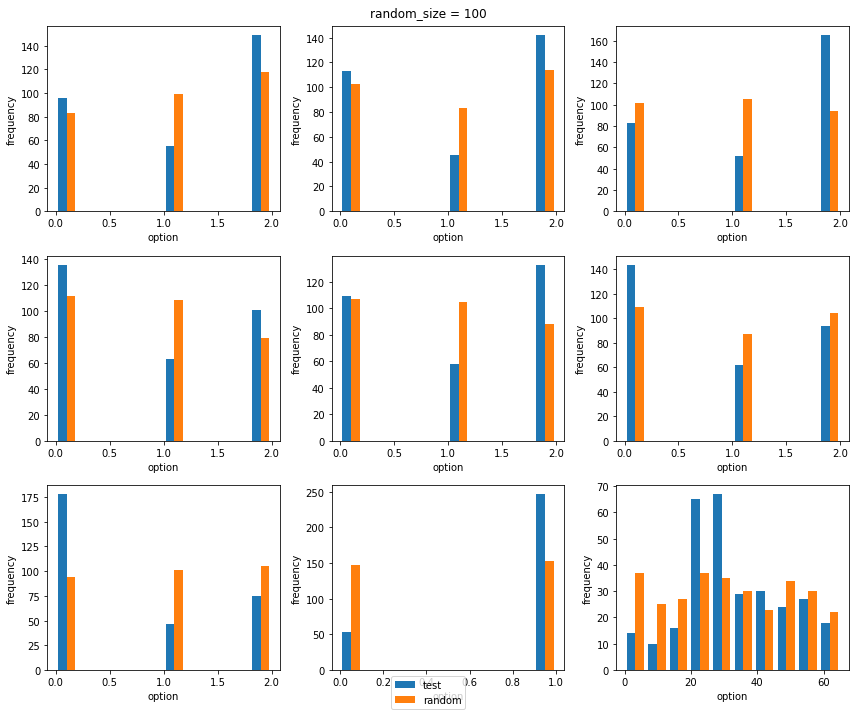

In [30]:
fig, axs = plt.subplots(3,3, figsize=(12,10))

for index in range(0,9):
    # plotting
    axs[index//3][index%3].hist([sample_test[:,index], sample_random[:,index]], label=["test", "random"])

    axs[index//3][index%3].set_xlabel("option")
    axs[index//3][index%3].set_ylabel("frequency")
    # axs[index//3][index%3].legend()
    
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')
fig.suptitle(f"random_size = {random_size}")    

plt.tight_layout()  # to avoid overlapping titles
plt.show()

(array([ 96.,   0.,   0.,   0.,   0.,  55.,   0.,   0.,   0., 149.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

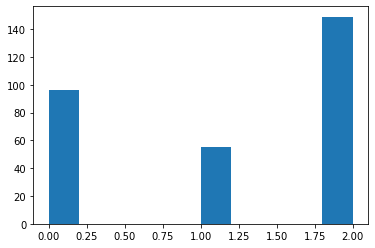

In [23]:
plt.hist(sample_test[:,0])

# Denoise algorithm

In [61]:
prob_random = np.zeros((SAMPLE_SIZE,))

for index_q in range(0,7):  # only 6 questions have radix 3
    ans_q = sample_test[:,index_q]

    bincount_q = np.bincount(ans_q)
    prob_q = np.select(
        [ans_q==0, ans_q==1, ans_q==2], 
        [(SAMPLE_SIZE-bincount_q[0])/SAMPLE_SIZE, (SAMPLE_SIZE-bincount_q[1])/SAMPLE_SIZE, (SAMPLE_SIZE-bincount_q[2])/SAMPLE_SIZE],
        0
    )

    prob_random += prob_q

In [151]:
ans_q = sample_test[:,0]
ans_q

array([2, 2, 1, 1, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 1, 1, 1, 2, 1, 2, 2, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 1, 1, 1,
       2, 0, 2, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 2, 2, 2, 1, 2, 1,
       2, 1, 1, 1, 0, 2, 1, 2, 1, 2, 0, 1, 1, 1, 0, 0, 0, 2, 2, 1, 2, 0,
       2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 1, 0, 2, 2,
       2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 0, 2, 2, 0, 0, 0, 1, 2,
       0, 0, 2, 2, 2, 0, 2, 0, 1, 2, 2, 0, 0, 2, 1, 1, 1, 0, 2, 2, 2, 0,
       0, 2, 2, 2, 0, 0, 2, 0, 1, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2,
       0, 2, 2, 1, 2, 2, 0, 0, 2, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2,
       0, 2, 2, 2, 1, 2, 1, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,
       0, 2, 2, 2, 0, 2, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 2, 1, 0, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2])

In [152]:
np.bincount(ans_q)

array([ 96,  55, 149])

In [153]:
bincount_q = np.bincount(ans_q)
bincount_q

array([ 96,  55, 149])

(array([ 96.,   0.,   0.,   0.,   0.,  55.,   0.,   0.,   0., 149.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

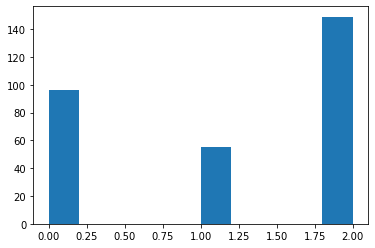

In [154]:
plt.hist(ans_q)

<AxesSubplot:xlabel='Response Index (first 100 are random)', ylabel='P(random)'>

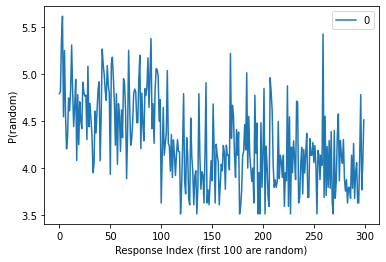

In [86]:
df_random = pd.DataFrame(prob_random)
df_random.plot(xlabel="Response Index (first 100 are random)", ylabel="P(random)")

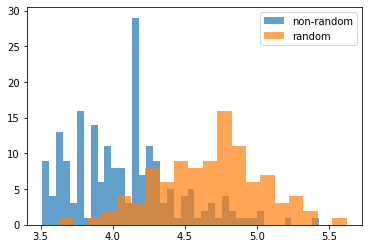

In [155]:
plt.hist(prob_random[101:], label="non-random", alpha=0.7, bins=40)
plt.hist(prob_random[:101], label="random", alpha=0.7, bins=20)
plt.legend()

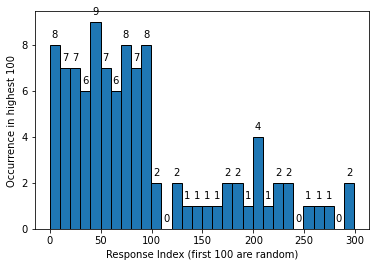

In [113]:
fig, ax = plt.subplots()

ax.hist(df_random.sort_values(0)[-100:].index, 
         bins=30, edgecolor='black')
ax.set_xlabel("Response Index (first 100 are random)")
ax.set_ylabel("Occurrence in highest 100")

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

# Output data

Assume that we have some a priori knowledge of the randomness percentage (i.e. in this case 100 out of 300), then our output data would be something like below

In [93]:
indices = df_random.sort_values(0)[:-100].index
indices

Int64Index([119, 202, 269, 177, 227, 197, 135, 195, 253, 206,
            ...
            270, 174,  22,  91,  29,  14, 182,  82, 194, 198],
           dtype='int64', length=200)

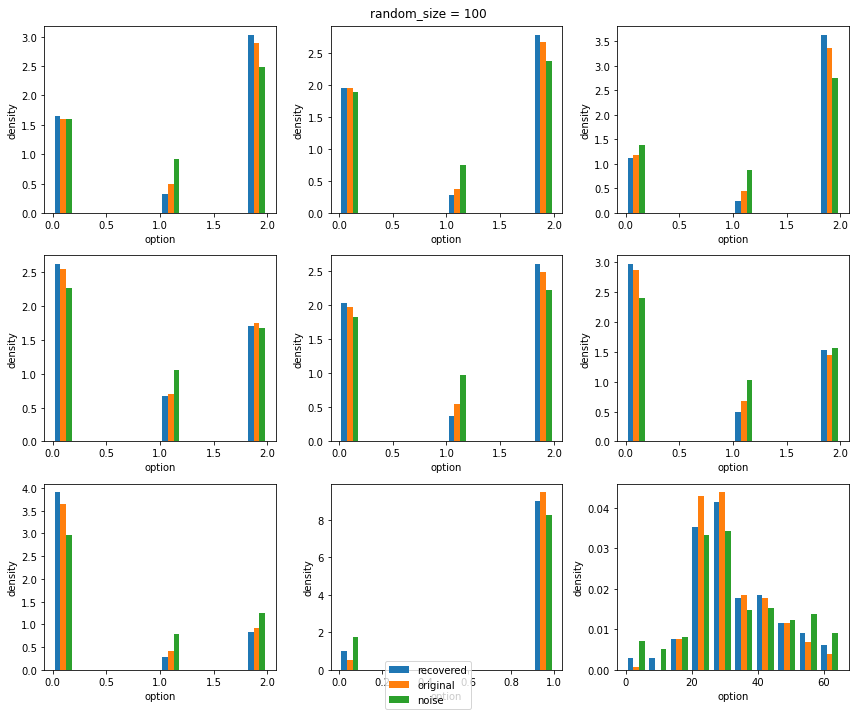

In [106]:
fig, axs = plt.subplots(3,3, figsize=(12,10))

for index in range(0,9):
    # plotting
    axs[index//3][index%3].hist([
        sample_test[indices,index], 
        sample_300[:200,index],
        sample_test[:,index],
    ], label=["recovered", "original", "noise"],
    density=True)

    axs[index//3][index%3].set_xlabel("option")
    axs[index//3][index%3].set_ylabel("density")
    # axs[index//3][index%3].legend()
    
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')
fig.suptitle(f"random_size = {random_size}")    

plt.tight_layout()  # to avoid overlapping titles
plt.show()

In [102]:
earth_mover_distance(sample_test[indices], sample_300[:200], radix, question_types)

88.2

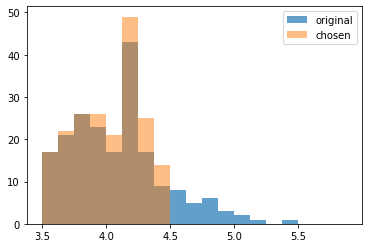

In [164]:
bins = np.arange(3.5,6.0,0.125)

plt.hist(prob_random[101:], label="original", alpha=0.7, bins=bins)
# plt.hist(prob_random[:101], label="random", alpha=0.3, bins=bins)
plt.hist(prob_random[indices], label="chosen", alpha=0.5, bins=bins)
plt.legend()

In [168]:
indices_dropped = np.setdiff1d(np.arange(0,300), indices)
indices_signal_lost = np.setdiff1d(indices_dropped, np.arange(0,100))
indices_random_remain = np.setdiff1d(np.arange(0,100), indices_dropped)

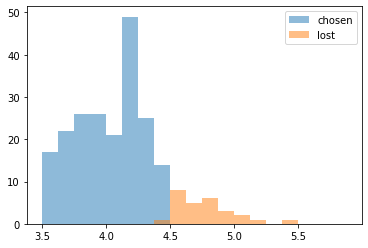

In [161]:
bins = np.arange(3.5,6.0,0.125)

# plt.hist(prob_random[101:], label="original", alpha=0.7, bins=bins, density=True)
# plt.hist(prob_random[:101], label="random", alpha=0.3, bins=bins, density=True)
plt.hist(prob_random[indices], label="chosen", alpha=0.5, bins=bins)
plt.hist(prob_random[indices_signal_lost], label="lost", alpha=0.5, bins=bins)
plt.legend()

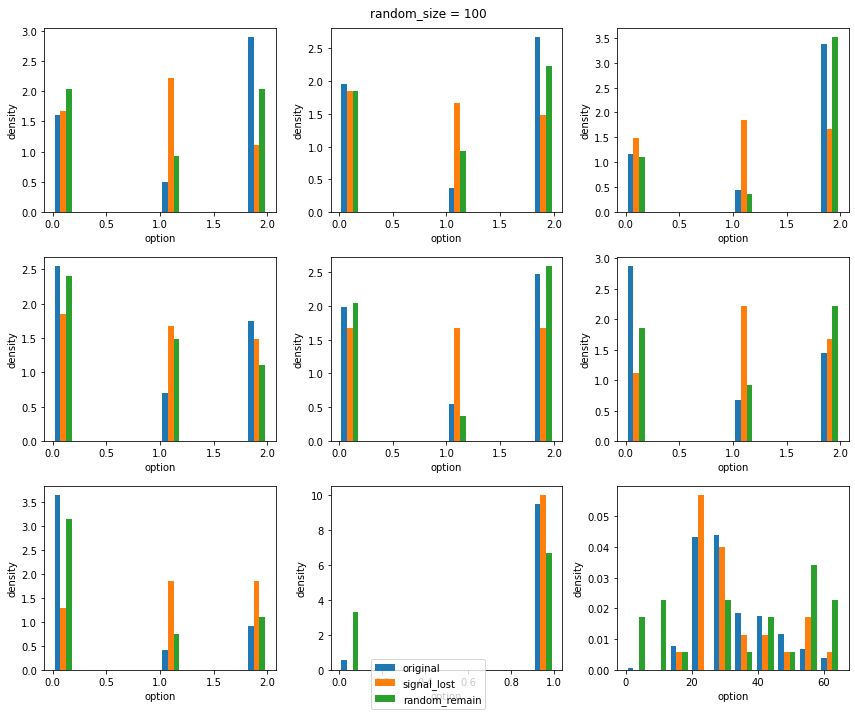

In [174]:
fig, axs = plt.subplots(3,3, figsize=(12,10))

for index in range(0,9):
    # plotting
    axs[index//3][index%3].hist([
        # sample_test[indices,index],
        sample_300[:200,index],
        sample_test[indices_signal_lost,index],
        sample_test[indices_random_remain,index],
    ], label=[
        # "recovered", 
        "original", 
        "signal_lost", 
        "random_remain"
    ],
    density=True)

    axs[index//3][index%3].set_xlabel("option")
    axs[index//3][index%3].set_ylabel("density")
    # axs[index//3][index%3].legend()
    
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')
fig.suptitle(f"random_size = {random_size}")    

plt.tight_layout()  # to avoid overlapping titles
plt.show()

# Second denoise algorithm

## DRAFT

In [179]:
np.bincount(sample_test[:,0])

array([ 96,  55, 149])

In [224]:
diff = 1/3 - (np.bincount(sample_test[:,0])/300)
diff * 3

array([ 0.04,  0.45, -0.49])

In [185]:
np.e

2.718281828459045

In [221]:
np.power(np.e,diff*100)

array([3.79366789e+00, 3.26901737e+06, 8.06349762e-08])

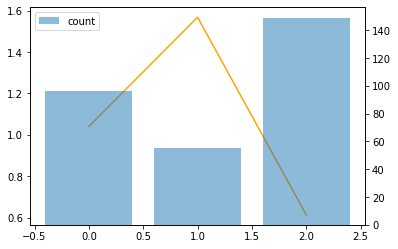

In [226]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(np.power(np.e, (1/3 - np.bincount(sample_test[:,0])/300)*3), label="score", color="orange")
ax2.bar(np.arange(0,3), np.bincount(sample_test[:,0]), label="count", alpha=0.5)
plt.legend()

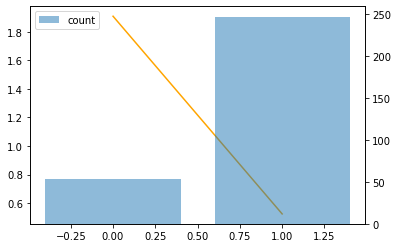

In [275]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(np.power(np.e, (1/2 - np.bincount(sample_test[:,7])/300)*2), label="score", color="orange")
ax2.bar(np.arange(0,2), np.bincount(sample_test[:,7]), label="count", alpha=0.5)
plt.legend()

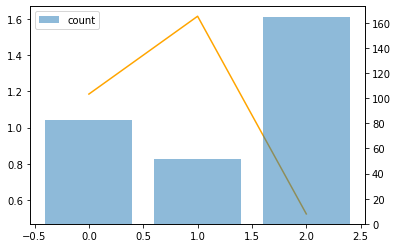

In [274]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(np.power(np.e, (1/3 - np.bincount(sample_test[:,2])/300)*3), label="score", color="orange")
ax2.bar(np.arange(0,3), np.bincount(sample_test[:,2]), label="count", alpha=0.5)
plt.legend()

In [186]:
radix

[3, 3, 3, 3, 3, 3, 3, 2, 65]

In [190]:
np.bincount(sample_test[:,8])

array([ 2,  4,  3,  1,  2,  1,  1,  2,  2,  1,  3,  0,  2,  0,  2,  3,  2,
        3,  1,  5,  4, 22,  9,  5,  9, 16, 14,  4, 12,  6, 13, 10,  8,  5,
        3,  3,  6,  5,  7,  5,  7,  4,  4,  5,  3,  2,  5,  2,  4,  4,  5,
        4,  5,  3,  2,  7,  1,  4,  5,  1,  5,  2,  7,  0,  2,  1])

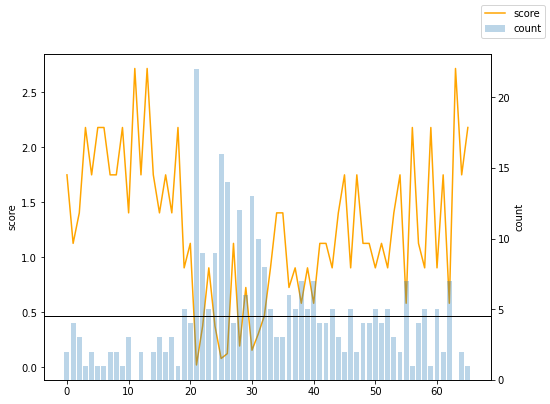

In [282]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()

ax1.plot(np.power(np.e, (1/66 - np.bincount(sample_test[:,8])/300)*66), label="score", color="orange")
# ax1.axhline(y=1,linewidth=1, color='green')
ax1.set_ylabel("score")

ax2.bar(np.arange(0,66), np.bincount(sample_test[:,8]), label="count", alpha=0.3)
ax2.axhline(y=300/66,linewidth=1, color='k')
ax2.set_ylabel("count")

fig.legend()

In [223]:
(1/66 - np.bincount(sample_test[:,8])/300) * 66

array([ 0.56,  0.12,  0.34,  0.78,  0.56,  0.78,  0.78,  0.56,  0.56,
        0.78,  0.34,  1.  ,  0.56,  1.  ,  0.56,  0.34,  0.56,  0.34,
        0.78, -0.1 ,  0.12, -3.84, -0.98, -0.1 , -0.98, -2.52, -2.08,
        0.12, -1.64, -0.32, -1.86, -1.2 , -0.76, -0.1 ,  0.34,  0.34,
       -0.32, -0.1 , -0.54, -0.1 , -0.54,  0.12,  0.12, -0.1 ,  0.34,
        0.56, -0.1 ,  0.56,  0.12,  0.12, -0.1 ,  0.12, -0.1 ,  0.34,
        0.56, -0.54,  0.78,  0.12, -0.1 ,  0.78, -0.1 ,  0.56, -0.54,
        1.  ,  0.56,  0.78])

array([ 2,  4,  3,  1,  2,  1,  1,  2,  2,  1,  3,  0,  2,  0,  2,  3,  2,
        3,  1,  5,  4, 22,  9,  5,  9, 16, 14,  4, 12,  6, 13, 10,  8,  5,
        3,  3,  6,  5,  7,  5,  7,  4,  4,  5,  3,  2,  5,  2,  4,  4,  5,
        4,  5,  3,  2,  7,  1,  4,  5,  1,  5,  2,  7,  0,  2,  1])

In [240]:
prob_random2 = np.zeros((SAMPLE_SIZE,))

for index_q in range(0,9):  # only 6 questions have radix 3
    ans_q = sample_test[:,index_q]

    bincount_q = np.bincount(ans_q)
    prob_q = np.select(
        [ans_q==i for i in np.arange(0,radix[index_q])], 
        np.power(np.e, (1/3 - bincount_q[:radix[index_q]]/300)*3),
        0
    )

    prob_random2 += prob_q

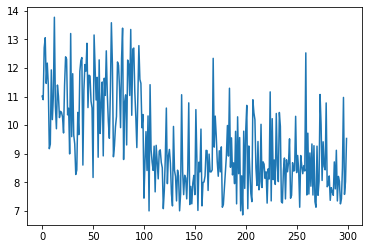

In [243]:
plt.plot(prob_random2)

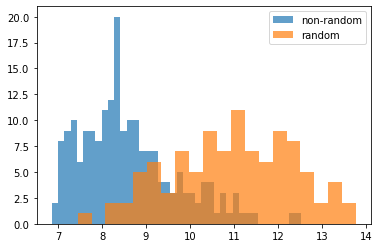

In [244]:
plt.hist(prob_random2[101:], label="non-random", alpha=0.7, bins=40)
plt.hist(prob_random2[:101], label="random", alpha=0.7, bins=20)
plt.legend()

In [248]:
np.searchsorted(np.sort(prob_random2), 11)

239

# Output data of 2nd

In [258]:
print(np.array(np.argsort(df_random[0])))

[119 202 269 177 227 197 135 195 253 206 178 225 221 157 132 128 147 293
 235 294 268 145 142 100 153 191 283 290 286 127 236 271 260 245 244 205
 262 239 124 281 179 146 297 163 139 288 266 120 136 264 213 199 211 284
 285 158 148 123 189 223 275 150 214 272 212 256 282 232 280  66 216 111
 219 173 133 114 141  50 241 229  33 196 222 291 140 131 109 160 134 167
 190 185 188 252 210 258 237 204 159  57 298  34 278 292 250 218 156  40
 149  17 231 138 295 287 187 255 155 130 180 175 143 172 277 166 257 165
 217 103 113 247 101 248 220 126 200 115 193 162 242 118 117 181  60 152
 254 183 240   7  80 238 228 121 263 108 203 161 251 164  55  70  19 154
 104 107  93 289 249 230  83 265 276 112 116  27 279  71 246 169  62 125
   8  32 273 110 243  36 105 176 267  67 270 174  22  91  29  14 182  82
 194 198  77  76 215  98  21  72 299  31 129   4 226 186 171 261  41  59
   6 274  35  10  65 209  61  37 102  88  15 170  69 151  58  92  30  54
  20 234 233  46  99   9  25  85 192  26  18 296  5

In [252]:
df_random[0]

0      4.793333
1      4.816667
2      5.360000
3      5.620000
4      4.546667
         ...   
295    4.126667
296    4.783333
297    3.766667
298    4.046667
299    4.513333
Name: 0, Length: 300, dtype: float64

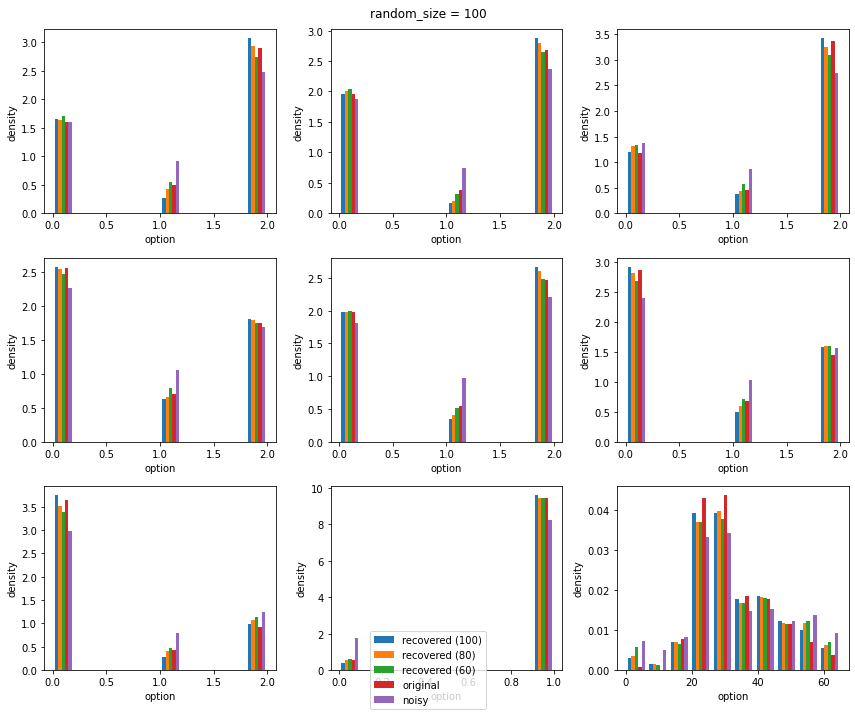

In [262]:
fig, axs = plt.subplots(3,3, figsize=(12,10))

for index in range(0,9):
    # plotting
    axs[index//3][index%3].hist([
        sample_test[np.argsort(prob_random2)[:-100],index], 
        sample_test[np.argsort(prob_random2)[:-80],index],
        sample_test[np.argsort(prob_random2)[:-60],index],
        sample_300[:200,index],
        sample_test[:,index],
    ], label=[
        "recovered (100)", 
        "recovered (80)", 
        "recovered (60)", 
        "original", 
        "noisy"
    ],
    density=True)

    axs[index//3][index%3].set_xlabel("option")
    axs[index//3][index%3].set_ylabel("density")
    # axs[index//3][index%3].legend()
    
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')
fig.suptitle(f"random_size = {random_size}")    

plt.tight_layout()  # to avoid overlapping titles
plt.show()

# END